In [ ]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=a8d6ceba7d8e2300e62402b2572c8fa03eece3929e9d1f0ae8a5d1d6403d4fe3
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="cuukZDMf6QLuizLNKlWP")
project = rf.workspace("aliud-videre").project("balls-detector-yl4ct")
dataset = project.version(4).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Balls-detector-4 in coco:: 100%|██████████| 569/569 [00:00<00:00, 2133.36it/s]


In [ ]:
!zip -r '/content/drive/MyDrive/for_colab/balls_detection/Balls-detector-4.zip' '/content/Balls-detector-4'

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/for_colab/balls_detection/Balls-detector-4.zip', 'r') as zipObj:
   zipObj.extractall('/content/drive/MyDrive/for_colab/balls_detection/') 

## Work

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

In [7]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # hIn pytorch, the input sould be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [8]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [9]:
train_data_dir = '/content/drive/MyDrive/for_colab/balls_detection/train'
train_coco = '/content/drive/MyDrive/for_colab/balls_detection/train/_annotations.coco.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )


test_data_dir = '/content/drive/MyDrive/for_colab/balls_detection/test'
tset_coco = '/content/drive/MyDrive/for_colab/balls_detection/test/_annotations.coco.json'

test_dataset = myOwnDataset(root=test_data_dir,
                          annotation=tset_coco,
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 27.0000, 156.0000,  76.0000, 192.0000],
        [ 24.0000, 281.0000,  70.5000, 314.5000],
        [143.0000, 202.0000, 190.5000, 238.0000],
        [330.0000, 262.0000, 377.5000, 298.0000],
        [343.0000, 127.0000, 387.5000, 164.5000],
        [389.0000, 135.0000, 434.5000, 171.0000],
        [463.0000, 122.0000, 510.0000, 158.0000],
        [445.0000, 156.0000, 491.5000, 192.0000],
        [426.0000, 187.0000, 472.0000, 222.5000],
        [453.0000, 216.0000, 500.0000, 251.0000],
        [474.0000, 183.0000, 523.0000, 219.0000],
        [424.0000, 244.0000, 472.0000, 279.0000],
        [455.0000, 281.0000, 503.0000, 316.5000],
        [476.0000, 250.0000, 524.0000, 285.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'image_id': tensor([158], device='cuda:0'), 'area': tensor([1764.0000, 1557.7500, 1710.0000, 1710.0000, 1668.7500, 1638.0000,
        1692.0000, 1674.0000, 1633.0000, 1645.0000, 1764.0000, 16

## Visualize the image from dataset and box from json file

In [10]:
import json
    
def find_idx(image_name, json_path):

  with open(json_path,'r') as load_f:
    f = json.load(load_f)
  df = f['images']
  idx_name = list(filter(lambda x:x["file_name"]==image_name,df))
  idx = idx_name[0]['id']
  return idx


In [11]:
def arr_point(image, json_path):

  coco=COCO(json_path)
  image_id = find_idx(image, json_path)
  annotation_ids = coco.getAnnIds(imgIds=image_id)
  anns = coco.loadAnns(annotation_ids)
  arr_point = []

  for i in range(len(anns)):
    anns_i = anns[i]
    bbox = anns_i['bbox']
    tensor_bbox = torch.Tensor(bbox).cpu()
    arr_point.append(tensor_bbox)

  return arr_point

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


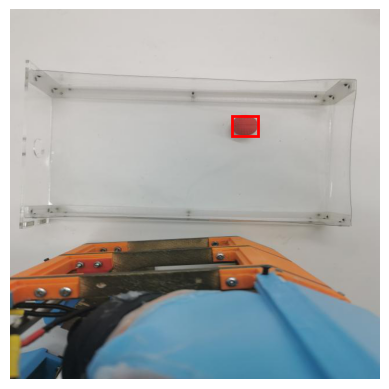

In [46]:
import matplotlib.pyplot as plt

images_path  = '/content/drive/MyDrive/for_colab/balls_detection/train/'
image_name = 'IMG_20230523_190332_jpg.rf.7b5b6ff757130815ff0ac24046817b0e.jpg'
arr_point_dataset = arr_point(image_name, train_coco)

image = Image.open(images_path +image_name)

fig, ax = plt.subplots()

for bbox in arr_point_dataset:
  x, y, w, h = [int(b) for b in bbox]
  rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
  ax.add_patch(rect)

ax.axis('off')
ax.imshow(image)
plt.show()
        

## Train model 

In [ ]:
def save_models(model, loss, epochs):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'loss': loss,
                }, '/content/drive/MyDrive/for_colab/balls_detection/model_epoch20.pt')

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

num_epochs = 20
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model.to(device)
    
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
len_dataloader = len(data_loader)

for epoch in tqdm(range(num_epochs)):
  model.train()
  loss_arr = []
  for imgs, annotations in data_loader:
      
      imgs = list(img.to(device) for img in imgs)
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
      loss_dict = model(imgs, annotations)
      losses = sum(loss for loss in loss_dict.values())
      loss_arr.append(losses)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

  save_models(model, losses, epoch)

  print(f'[Epoch {epoch + 1}] train loss: {losses:.3f}')


  0%|          | 0/20 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feb9c8ed510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feb9c8ed510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers


[Epoch 1] train loss: 1.174


 10%|█         | 2/20 [03:42<33:14, 110.80s/it]

[Epoch 2] train loss: 0.668


 15%|█▌        | 3/20 [05:31<31:10, 110.01s/it]

[Epoch 3] train loss: 1.121


 20%|██        | 4/20 [07:19<29:06, 109.15s/it]

[Epoch 4] train loss: 0.635


 25%|██▌       | 5/20 [09:06<27:09, 108.62s/it]

[Epoch 5] train loss: 0.713


 30%|███       | 6/20 [10:54<25:15, 108.25s/it]

[Epoch 6] train loss: 0.820


 35%|███▌      | 7/20 [12:42<23:25, 108.11s/it]

[Epoch 7] train loss: 0.800


 40%|████      | 8/20 [14:29<21:36, 108.04s/it]

[Epoch 8] train loss: 0.929


 45%|████▌     | 9/20 [16:18<19:48, 108.07s/it]

[Epoch 9] train loss: 0.793


 50%|█████     | 10/20 [18:06<18:00, 108.06s/it]

[Epoch 10] train loss: 0.434


 55%|█████▌    | 11/20 [19:54<16:12, 108.09s/it]

[Epoch 11] train loss: 0.534


 60%|██████    | 12/20 [21:42<14:24, 108.05s/it]

[Epoch 12] train loss: 0.661


 65%|██████▌   | 13/20 [23:30<12:36, 108.10s/it]

[Epoch 13] train loss: 0.512


 70%|███████   | 14/20 [25:18<10:48, 108.12s/it]

[Epoch 14] train loss: 0.447


 75%|███████▌  | 15/20 [27:06<09:00, 108.14s/it]

[Epoch 15] train loss: 0.570


 80%|████████  | 16/20 [28:55<07:12, 108.18s/it]

[Epoch 16] train loss: 0.423


 85%|████████▌ | 17/20 [30:43<05:24, 108.17s/it]

[Epoch 17] train loss: 0.509


 90%|█████████ | 18/20 [32:31<03:36, 108.28s/it]

[Epoch 18] train loss: 0.598


 95%|█████████▌| 19/20 [34:20<01:48, 108.45s/it]

[Epoch 19] train loss: 0.295


100%|██████████| 20/20 [36:09<00:00, 108.46s/it]

[Epoch 20] train loss: 0.514


In [ ]:
#from tensor list to array

loss_value = []
for i in range(len(loss_arr)):
  value = loss_arr[i].tolist()
  loss_value.append(value)

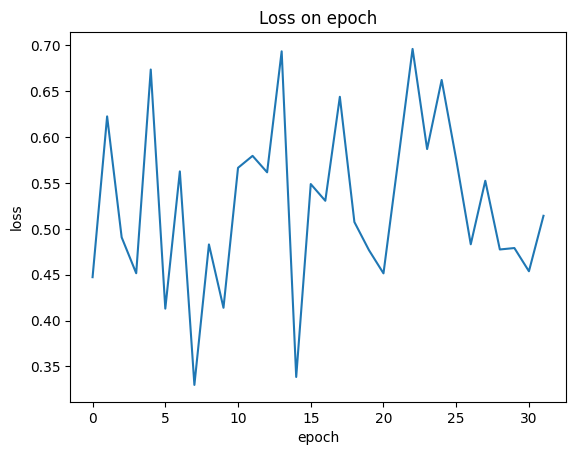

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_value)
plt.xlabel('epoch')
plt.ylabel('loss')
  
plt.title('Loss on epoch')

plt.show()

## Prediction on Test Images

In [12]:
#load model with weight

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model_dict = torch.load('/content/drive/MyDrive/for_colab/balls_detection/model_epoch20.pt')
model.load_state_dict(model_dict['model_state_dict'])

model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [13]:
import cv2

def predict(path,model):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float()
  input = []
  input.append(img_tensor)

  out2 = model(input)
  dict_predict = out2[0]
  tensor_box = dict_predict['boxes']
  predict_scores = dict_predict['scores'].detach().numpy()

  predict_point = []
  for i in range(len(tensor_box)):
    # if predict_scores[i] >= 0.85:
    anns_i = tensor_box[i]
    predict_point.append(anns_i)

  return predict_point

In [14]:
def plot_all_rect(ax, predict_point, orig_point):
  
  for idx in range(len(predict_point)):
    numpy_point = predict_point[idx].detach().numpy()
    x, y, w, h = numpy_point[0], numpy_point[1], (numpy_point[2] - numpy_point[0]), (numpy_point[3] - numpy_point[1])
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

  for idx in range(len(orig_point)):
    numpy_orig = orig_point[idx].detach().numpy()
    x, y, w, h = numpy_orig[0], numpy_orig[1], numpy_orig[2], numpy_orig[3]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

### result without sorting bboxes

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


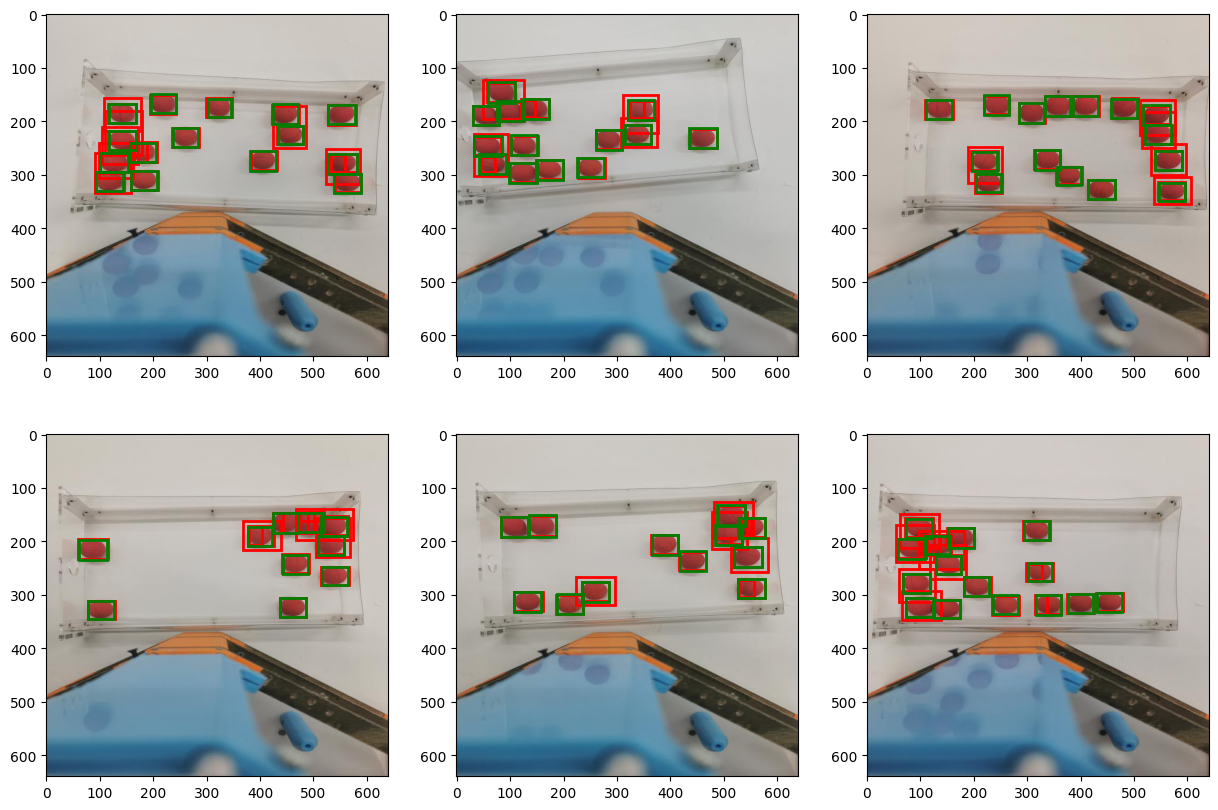

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import random

folder_path = "/content/drive/MyDrive/for_colab/balls_detection/test/"
fig = plt.figure(figsize=(15, 10))
# fig. tight_layout ()
columns = 3
rows = 2
# fig, axs = plt.subplots(nrows= rows , ncols= columns)
img_list = os.listdir(test_data_dir)
random_img = random.choices(img_list,k=columns*rows)
ax = []

for i in range(1, columns*rows +1):

  img_path = folder_path + random_img[i-1]
  image = Image.open(img_path)
  ax.append( fig.add_subplot(rows, columns, i) )
  
  plt.imshow(image)

for i in range(1, columns*rows +1):
  img_path = folder_path + random_img[i-1]
  image = Image.open(img_path)
  predict_point = predict(img_path, model)
  orig_point = arr_point(random_img[i-1], tset_coco)
  plot_all_rect(ax[i-1], predict_point, orig_point)

plt.show()

## Average IoU on test images

In [20]:
def get_iou(gt, pred):


  # coordinates of the area of intersection.
  ix1 = np.maximum(gt[0], pred[0])
  iy1 = np.maximum(gt[1], pred[1])
  ix2 = np.minimum((gt[2]+gt[0]), pred[2])
  iy2 = np.minimum((gt[3]+gt[1]), pred[3])

  # Intersection height and width.
  i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
  i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

  area_of_intersection = i_height * i_width
 
  # Ground Truth dimensions.
  gt_height = (gt[3]+gt[1]) - gt[1] + 1
  gt_width = (gt[2]+gt[0]) - gt[0] + 1
    
  # Prediction dimensions.
  pd_height = pred[3] - pred[1] + 1
  pd_width = pred[2] - pred[0] + 1
    
  area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
  iou = area_of_intersection / area_of_union
     
  return iou

In [21]:
#find best bbox for ONE image
def iou_comp(orig_point, predict_point):
  compare_dict = {}
  iou_list = []

  for i in range(len(orig_point)):
    gt = orig_point[i].detach().numpy()
    arr_iou = []
    for j in range(len(predict_point)):
      pred = predict_point[j].detach().numpy()
      iou_value = get_iou(gt, pred)
      if iou_value > 0.5:
        compare_dict[i] = j
        iou_list.append(iou_value)
  return compare_dict, iou_list 

In [223]:
#for EACH photo in test loader
from tqdm import tqdm
common_iou_value = []

folder_path = "/content/drive/MyDrive/for_colab/balls_detection/test/"
img_list = os.listdir(test_data_dir)
for i in tqdm(range(len(img_list))):
  img_path = folder_path + img_list[i]
  image = Image.open(img_path)
  orig_point = arr_point(img_list[i], tset_coco)
  # print('true number of ball', len(orig_point))
  predict_point = predict(img_path, model)
  
  iou_dict,iou_list = iou_comp(orig_point, predict_point)
  common_iou_value.extend(iou_list)
  # best_pred_bbox = list(iou_dict.values())
  # print('predict number of ball', len(best_pred_bbox))

  0%|          | 0/31 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  3%|▎         | 1/31 [00:04<02:04,  4.14s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  6%|▋         | 2/31 [00:09<02:24,  4.98s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 10%|▉         | 3/31 [00:13<02:07,  4.56s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 13%|█▎        | 4/31 [00:17<01:58,  4.40s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 16%|█▌        | 5/31 [00:24<02:10,  5.04s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 19%|█▉        | 6/31 [00:29<02:09,  5.17s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 23%|██▎       | 7/31 [00:34<02:06,  5.26s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 26%|██▌       | 8/31 [00:39<01:57,  5.12s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 29%|██▉       | 9/31 [00:43<01:45,  4.80s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 32%|███▏      | 10/31 [00:49<01:46,  5.05s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 35%|███▌      | 11/31 [00:54<01:40,  5.01s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 39%|███▊      | 12/31 [00:58<01:29,  4.70s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 42%|████▏     | 13/31 [01:03<01:29,  4.95s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 45%|████▌     | 14/31 [01:07<01:19,  4.67s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 48%|████▊     | 15/31 [01:12<01:12,  4.52s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 52%|█████▏    | 16/31 [01:17<01:12,  4.87s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 55%|█████▍    | 17/31 [01:22<01:06,  4.76s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 58%|█████▊    | 18/31 [01:26<01:00,  4.68s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 61%|██████▏   | 19/31 [01:33<01:03,  5.33s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 65%|██████▍   | 20/31 [01:38<00:57,  5.21s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 68%|██████▊   | 21/31 [01:43<00:51,  5.19s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 71%|███████   | 22/31 [01:49<00:48,  5.40s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 74%|███████▍  | 23/31 [01:54<00:42,  5.36s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 77%|███████▋  | 24/31 [02:01<00:39,  5.69s/it]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


 81%|████████  | 25/31 [02:05<00:30,  5.01s/it]


UnidentifiedImageError: ignored

In [224]:
import statistics
print('Average IoU on test images:', statistics.mean(common_iou_value))

Average IoU on test images: 0.8563237957219482


## Plot several image with best bbox

In [15]:
def plot_rect(ax, predict_point, orig_point, best_pred_bbox):
  for idx in best_pred_bbox:
    numpy_point = predict_point[idx].detach().numpy()
    x, y, w, h = numpy_point[0], numpy_point[1], (numpy_point[2] - numpy_point[0]), (numpy_point[3] - numpy_point[1])
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

  for idx in range(len(orig_point)):
    numpy_orig = orig_point[idx].detach().numpy()
    x, y, w, h = numpy_orig[0], numpy_orig[1], numpy_orig[2], numpy_orig[3]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
true number of ball 15
predict number of ball 15
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
true number of ball 13
predict number of ball 13
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
true number of ball 11
predict number of ball 11
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
true number of ball 15
predict number of ball 15
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
true number of ball 13
predict number of ball 13
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
true number of ball 14
predict number of ball 14


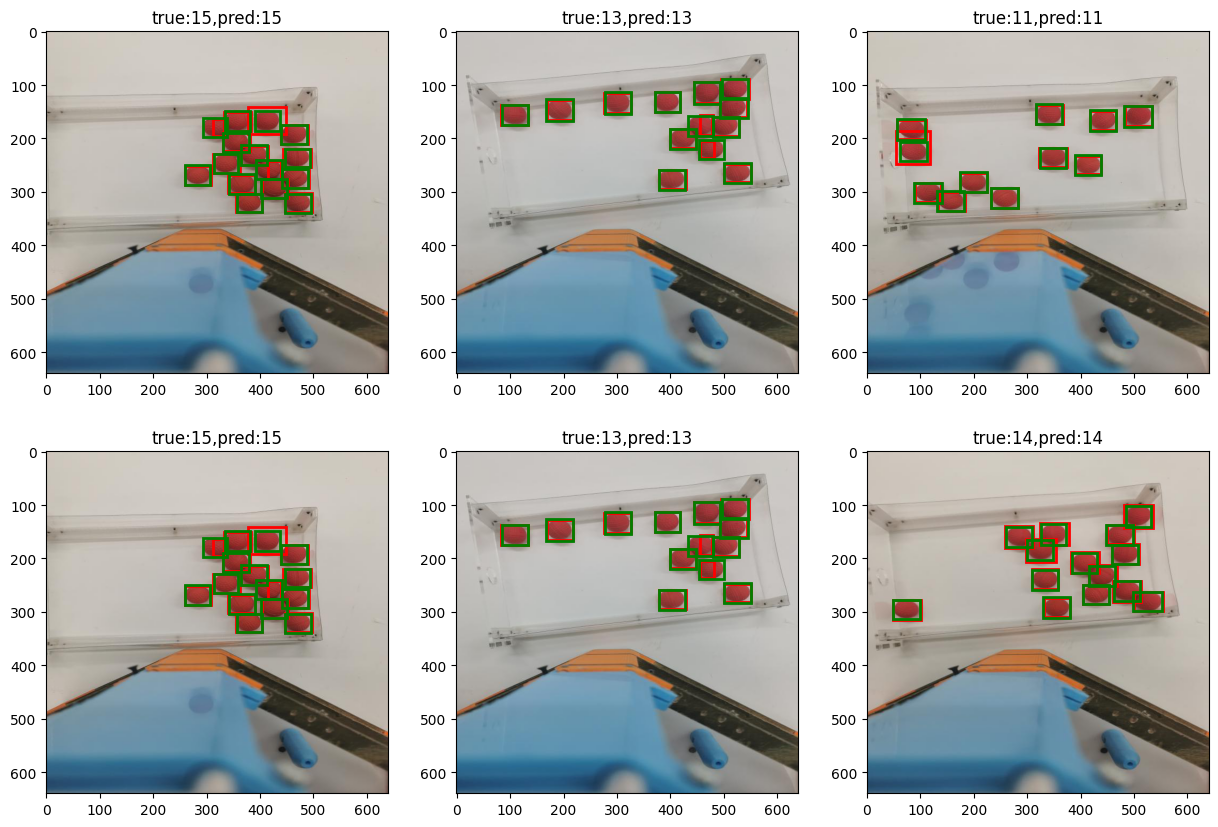

In [221]:
folder_path = "/content/drive/MyDrive/for_colab/balls_detection/test/"
fig = plt.figure(figsize=(15, 10))

columns = 3
rows = 2

img_list = os.listdir(test_data_dir)
random_img = random.choices(img_list,k=columns*rows)
ax = []

for i in range(1, columns*rows +1):

  img_path = folder_path + random_img[i-1]
  image = Image.open(img_path)
  ax.append( fig.add_subplot(rows, columns, i) )
  
  plt.imshow(image)

for i in range(1, columns*rows +1):
  img_path = folder_path + random_img[i-1]
  image = Image.open(img_path)
  orig_point = arr_point(random_img[i-1], tset_coco)
  
  print('true number of ball', len(orig_point))
  predict_point = predict(img_path, model)
  #list of best predicrion bbox
  iou_dict,iou_list = iou_comp(orig_point, predict_point)
  best_pred_bbox = list(iou_dict.values())
  print('predict number of ball', len(best_pred_bbox))
  ax[i-1].set_title('true:{},pred:{}'.format( len(orig_point),len(best_pred_bbox)))
  plot_rect(ax[i-1], predict_point, orig_point, best_pred_bbox)

plt.show()

In [16]:
def predict_th(path,model,threshold):
 
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float()
  input = []
  input.append(img_tensor)

  out2 = model(input)
  dict_predict = out2[0]
  tensor_box = dict_predict['boxes']
  predict_scores = dict_predict['scores'].detach().numpy()

  predict_point = []
  for i in range(len(tensor_box)):
    if predict_scores[i] >= threshold:
      anns_i = tensor_box[i]
      predict_point.append(anns_i)

  return predict_point

In [17]:
def best_sigle_bbox(predict_point):
  best_bboxes = []
  for i in range(len(predict_point)):
    for j in range(1,len(predict_point)):
      iou_value = get_iou(predict_point[i], predict_point[j])
      if iou_value > 0.95:
        best_bboxes.extend(predict_point[i])
      else:
        continue

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[tensor([205.9290, 155.9160, 255.3836, 192.2896], grad_fn=<SelectBackward0>), tensor([338.6552, 175.4176, 387.7041, 210.8432], grad_fn=<SelectBackward0>), tensor([489.0633, 218.1913, 539.0504, 253.1210], grad_fn=<SelectBackward0>), tensor([355.1496, 286.6876, 404.7328, 322.6804], grad_fn=<SelectBackward0>)]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[tensor([327.6821, 195.6132, 376.7147, 230.9443], grad_fn=<SelectBackward0>), tensor([515.4166, 195.0002, 565.3785, 229.7240], grad_fn=<SelectBackward0>), tensor([456.8752, 277.3215, 505.8365, 312.0077], grad_fn=<SelectBackward0>), tensor([319.9152, 258.7623, 369.1400, 293.4099], grad_fn=<SelectBackward0>), tensor([376.9393, 324.9796, 426.4751, 360.2984], grad_fn=<SelectBackward0>), tensor([469.8198, 235.8190, 519.3752, 270.3094], grad_fn=<SelectBackward0>), tensor([489.1827, 303.6931, 539.8354, 339.3663], grad_fn=<Sele

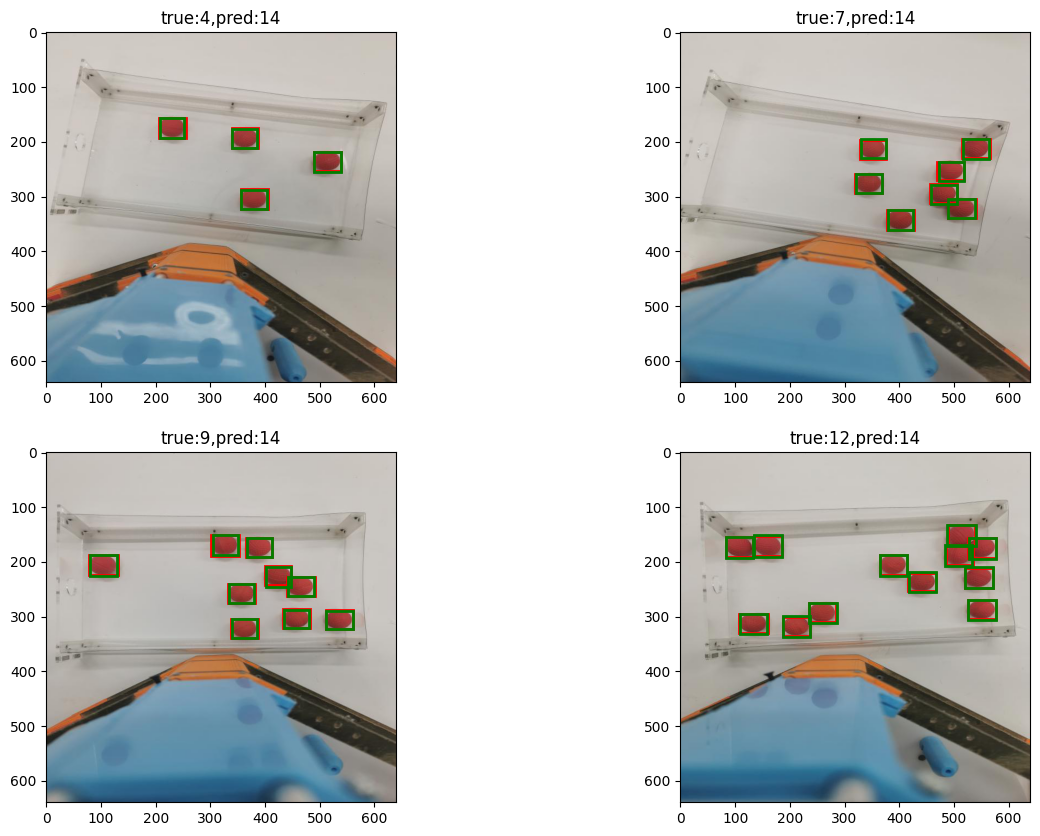

In [257]:
folder_path = "/content/drive/MyDrive/for_colab/balls_detection/test/"
fig = plt.figure(figsize=(15, 10))

columns = 2
rows = 2

img_list = os.listdir(test_data_dir)
random_img = random.choices(img_list,k=columns*rows)
ax = []

for i in range(1, columns*rows +1):

  img_path = folder_path + random_img[i-1]
  image = Image.open(img_path)
  ax.append( fig.add_subplot(rows, columns, i) )
  
  plt.imshow(image)

for i in range(1, columns*rows +1):
  img_path = folder_path + random_img[i-1]
  image = Image.open(img_path)
  orig_point = arr_point(random_img[i-1], tset_coco)
  threshold = 0.9
  predict_point = predict_th(img_path, model,threshold)
  # bbbox = best_sigle_bbox(predict_point)
  #list of best predicrion bbox
  # iou_dict,iou_list = iou_comp(orig_point, predict_point)
  # best_pred_bbox = list(iou_dict.values())
  # print(bbbox)
  ax[i-1].set_title('true:{},pred:{}'.format( len(orig_point),len(best_pred_bbox)))
  plot_all_rect(ax[i-1], predict_point, orig_point)

plt.show()

In [33]:
def get_pred_iou(gt, pred):


  # coordinates of the area of intersection.
  ix1 = np.maximum(gt[0], pred[0])
  iy1 = np.maximum(gt[1], pred[1])
  ix2 = np.minimum(gt[2], pred[2])
  iy2 = np.minimum(gt[3], pred[3])

  # Intersection height and width.
  i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
  i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

  area_of_intersection = i_height * i_width
 
  # Ground Truth dimensions.
  gt_height = gt[3] - gt[1] + 1
  gt_width = gt[2] - gt[0] + 1
    
  # Prediction dimensions.
  pd_height = pred[3] - pred[1] + 1
  pd_width = pred[2] - pred[0] + 1
    
  area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
  iou = area_of_intersection / area_of_union
     
  return iou

In [36]:
def best_sigle_bbox(predict_point):
  best_bboxes = []
  for i in range(len(predict_point)):
    i_point = predict_point[i].detach().numpy()
    print('i',i_point)
    for j in range(1,len(predict_point)):
      j_point = predict_point[j].detach().numpy()
      print('j',j_point)
      iou_value = get_pred_iou(i_point, j_point)
      print(iou_value)
      if iou_value >= 0.9:
          best_bboxes.extend(predict_point[i])
      else:
        continue
    print('-----------------------------')

In [37]:
images_path  = '/content/drive/MyDrive/for_colab/balls_detection/test/'
# /content/drive/MyDrive/for_colab/balls_detection/test/IMG_20230523_193901_jpg.rf.a776ade5156f8249a79635dc5a0e0103.jpg
image_name = 'IMG_20230523_193901_jpg.rf.a776ade5156f8249a79635dc5a0e0103.jpg'
orig_point = arr_point(image_name, tset_coco)
image = Image.open(images_path + image_name)

threshold = 0.9

predict_point = predict_th((images_path +image_name), model,threshold)
print(predict_point)
bbbox = best_sigle_bbox(predict_point)
print(bbbox)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[tensor([ 24.4821, 152.2973,  82.9060, 193.1753], grad_fn=<SelectBackward0>), tensor([ 27.1018, 225.2817,  84.7473, 265.8727], grad_fn=<SelectBackward0>), tensor([284.4917, 152.2820, 336.1366, 191.6710], grad_fn=<SelectBackward0>), tensor([ 31.5658, 283.1328,  86.1642, 321.4077], grad_fn=<SelectBackward0>), tensor([214.3892, 212.6729, 266.6233, 250.5455], grad_fn=<SelectBackward0>), tensor([ 93.2149, 150.7392, 148.2923, 189.7942], grad_fn=<SelectBackward0>), tensor([253.9030, 254.7958, 306.6130, 294.1878], grad_fn=<SelectBackward0>), tensor([152.3938, 277.8709, 210.4624, 315.9848], grad_fn=<SelectBackward0>), tensor([165.3754, 241.2749, 223.0482, 282.5603], grad_fn=<SelectBackward0>), tensor([ 78.5515, 217.3725, 138.3640, 260.8445], grad_fn=<SelectBackward0>), tensor([103.7253, 249.6923, 169.1410, 295.3376], grad_fn=<SelectBackward0>), tensor([ 46.6306, 181.0426, 103.8140, 224.3078], grad_fn=<SelectBackw

In [27]:
images_path  = '/content/drive/MyDrive/for_colab/balls_detection/test/'
# /content/drive/MyDrive/for_colab/balls_detection/test/IMG_20230523_193901_jpg.rf.a776ade5156f8249a79635dc5a0e0103.jpg
image_name = 'IMG_20230523_193901_jpg.rf.a776ade5156f8249a79635dc5a0e0103.jpg'
orig_point = arr_point(image_name, tset_coco)
image = Image.open(images_path + image_name)

threshold = 0.5

predict_point = predict_th((images_path +image_name), model,threshold)
print(predict_point)
bbbox = best_sigle_bbox(predict_point)
print(bbbox)

fig, ax = plt.subplots()

plot_all_rect(ax, predict_point, orig_point)
ax.axis('off')
ax.set_title('true:{},pred:{}'.format(len(orig_point),len(predict_point)))
ax.imshow(image)
plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[tensor([ 24.4821, 152.2973,  82.9060, 193.1753], grad_fn=<SelectBackward0>), tensor([ 27.1018, 225.2817,  84.7473, 265.8727], grad_fn=<SelectBackward0>), tensor([284.4917, 152.2820, 336.1366, 191.6710], grad_fn=<SelectBackward0>), tensor([ 31.5658, 283.1328,  86.1642, 321.4077], grad_fn=<SelectBackward0>), tensor([214.3892, 212.6729, 266.6233, 250.5455], grad_fn=<SelectBackward0>), tensor([ 93.2149, 150.7392, 148.2923, 189.7942], grad_fn=<SelectBackward0>), tensor([253.9030, 254.7958, 306.6130, 294.1878], grad_fn=<SelectBackward0>), tensor([152.3938, 277.8709, 210.4624, 315.9848], grad_fn=<SelectBackward0>), tensor([165.3754, 241.2749, 223.0482, 282.5603], grad_fn=<SelectBackward0>), tensor([ 78.5515, 217.3725, 138.3640, 260.8445], grad_fn=<SelectBackward0>), tensor([103.7253, 249.6923, 169.1410, 295.3376], grad_fn=<SelectBackward0>), tensor([ 46.6306, 181.0426, 103.8140, 224.3078], grad_fn=<SelectBackw

RuntimeError: ignored